# ⚡ 03 - Forecasting af elspotpriser

Denne notebook anvender den bedste trænede GRU-model til at forudsige elspotpriser for det næste døgn baseret på vejrudsigten.  
Notebook’en er sidste trin i projektet og viser, hvordan data hentes, forbehandles og anvendes til at generere en dynamisk prisprognose.


In [1]:
import json
import torch
from torch import nn
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
import requests
import joblib




In [2]:


with open("../models/best_params.json", "r") as f:
    best_params = json.load(f)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Running on:", device)


# --- Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size=None, num_layers=None, dropout=None):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # ét output per time

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out)
        return out




best_model = GRUModel(
    input_size=5,
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    dropout=best_params["dropout"]
).to(device)

best_model.load_state_dict(torch.load("../models/best_model.pt", map_location=device))
best_model.eval()



Running on: cpu


GRUModel(
  (gru): GRU(5, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [3]:


def fetch_weather_forecast(lat=56.2, lon=10.5):
    """
    Hent vejrprognose for næste døgn (00–23 dansk tid) fra Open-Meteo API.
    Returnerer DataFrame med samme kolonner som fetch_weather_data.
    """
    url = "https://api.open-meteo.com/v1/forecast"

    # find næste midnat og slut på det døgn
    now = datetime.now()
    start = (now + timedelta(days=1)).replace(hour=0, minute=0, second=0, microsecond=0)
    end = start + timedelta(hours=23)

    params = {
        "latitude": lat,
        "longitude": lon,
        "start_hour": start.strftime("%Y-%m-%dT%H:%M"),
        "end_hour": end.strftime("%Y-%m-%dT%H:%M"),
        "hourly": ["temperature_2m", "windspeed_10m", "shortwave_radiation"],
        "timezone": "Europe/Copenhagen"
    }

    r = requests.get(url, params=params)
    r.raise_for_status()
    data = r.json()

    df_forecast = pd.DataFrame({
        "TimeDK": pd.to_datetime(data["hourly"]["time"]),
        "Temperature": data["hourly"]["temperature_2m"],
        "WindSpeed": data["hourly"]["windspeed_10m"],
        "SolarRadiation": data["hourly"]["shortwave_radiation"]
    })

    # behold kun det kommende døgn 00–23
    df_forecast = df_forecast[
        (df_forecast["TimeDK"] >= start) & (df_forecast["TimeDK"] <= end)
    ].reset_index(drop=True)

     # tilføj time of day og weekday
    df_forecast["hour"] = df_forecast["TimeDK"].dt.hour
    df_forecast["dow"] = df_forecast["TimeDK"].dt.dayofweek

    # behold kun de relevante kolonner i samme rækkefølge
    df_forecast = df_forecast[["Temperature", "WindSpeed", "SolarRadiation", "hour", "dow"]]

    return df_forecast




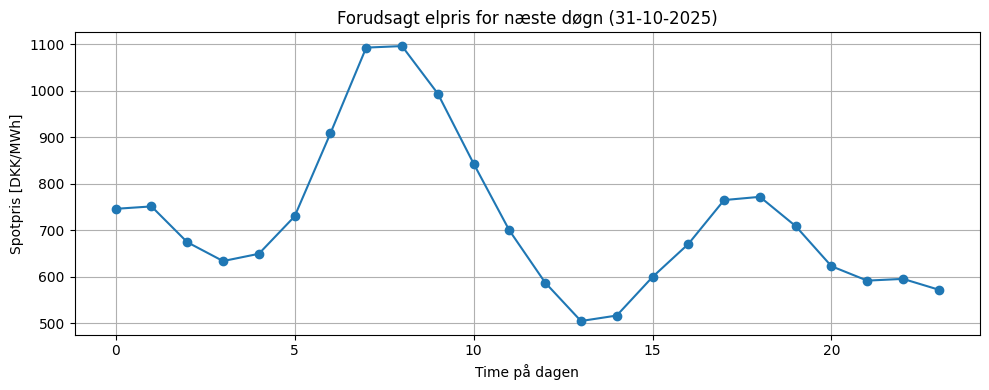

In [5]:

df_forecast = fetch_weather_forecast()



# --- Load scalers ---
scaler_X = joblib.load("../models/scaler_X.gz")
scaler_y = joblib.load("../models/scaler_y.gz")

X_forecast = scaler_X.transform(df_forecast[["Temperature", "WindSpeed", "SolarRadiation", "hour", "dow"]])
X_forecast = torch.tensor(X_forecast, dtype=torch.float32).unsqueeze(0)  # (1, 24, 5)

# --- 3. Lav forudsigelser ---
with torch.no_grad():
    y_pred_scaled = best_model(X_forecast).cpu().numpy()

# --- 4. Invers skalering ---
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.squeeze().reshape(-1, 1))


# --- 5. Plot resultatet ---

# --- Beregn dato for næste døgn ---
tomorrow = (datetime.now() + timedelta(days=1)).strftime("%d-%m-%Y")



plt.figure(figsize=(10,4))
plt.plot(range(24), y_pred_real, marker="o")
plt.title(f"Forudsagt elpris for næste døgn ({tomorrow})")
plt.xlabel("Time på dagen")
plt.ylabel("Spotpris [DKK/MWh]")
plt.grid(True)
plt.tight_layout()
plt.show()